In [213]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne 
from tqdm import tqdm
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.signal import periodogram
from scipy.signal import iirnotch, filtfilt, welch
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from pymultifracs.viz import plot_psd
from pymultifracs import mfa, wavelet_analysis

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from extract_envelopes import extract_envelopes_modes


In [215]:
%matplotlib inline

In [278]:
# Load results
modes_df = pd.read_csv("../results/real/benchmark/modes_df_with_enveloppes.csv")
features_df = pd.read_csv("../results/real/benchmark/features_df_kmeans.csv")

In [217]:
def load_signal(path):
    raw = mne.io.read_raw_fif(path, preload=True)
    raw_meg = raw.copy().pick('meg')
    data = raw_meg.get_data(return_times=False)
    return raw, data

raw, data_matrix = load_signal("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")

Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...


In [218]:
# Parameters
fs = 250  # Sampling frequency (Hz)
duration = 300.0  # Duration to plot (s)
output_base = "../results/real/"
n_channels_to_process = 306  
n_channels_for_benchmark = 10  # Only for benchmarking
max_points = 1000
methods = ["VMD"]

## 1. Signal exploration

In [219]:
raw

<Raw | sub-01_ses-01_task-rest_proc-filt_raw.fif, 356 x 82500 (330.0 s), ~224.6 MiB, data loaded>

Using matplotlib as 2D backend.


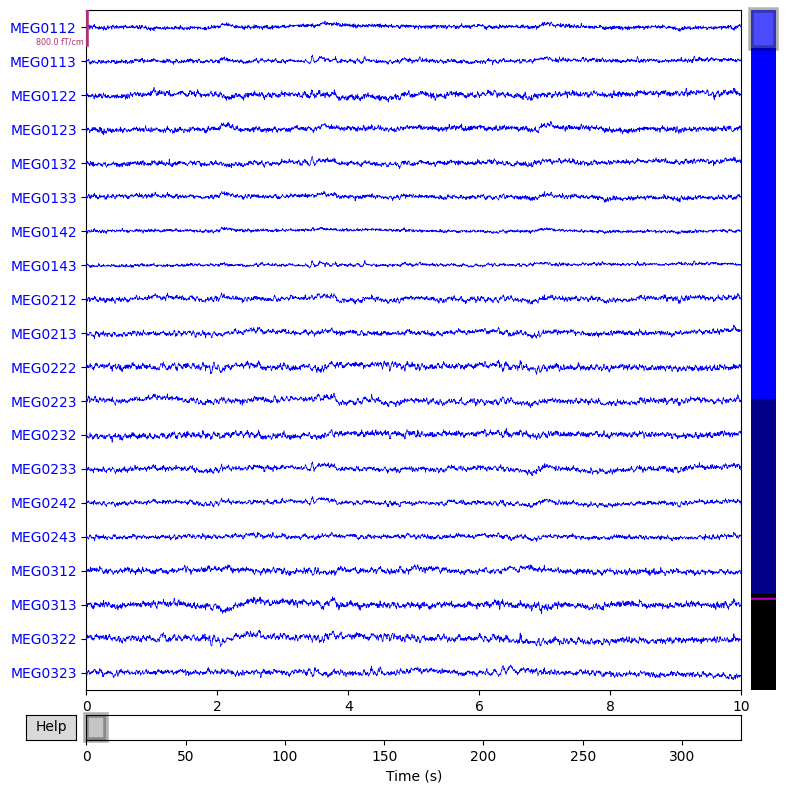

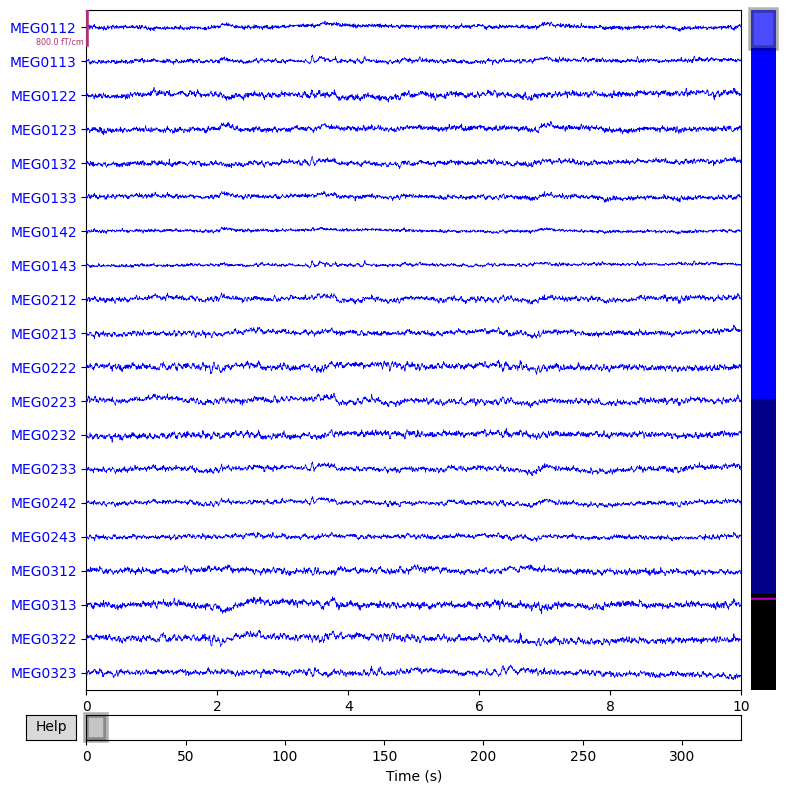

In [220]:
raw.plot()

In [221]:
print(data_matrix.shape)
type(data_matrix)

(306, 82500)


numpy.ndarray

In [222]:
sfreq = raw.info["sfreq"]
sfreq

250.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


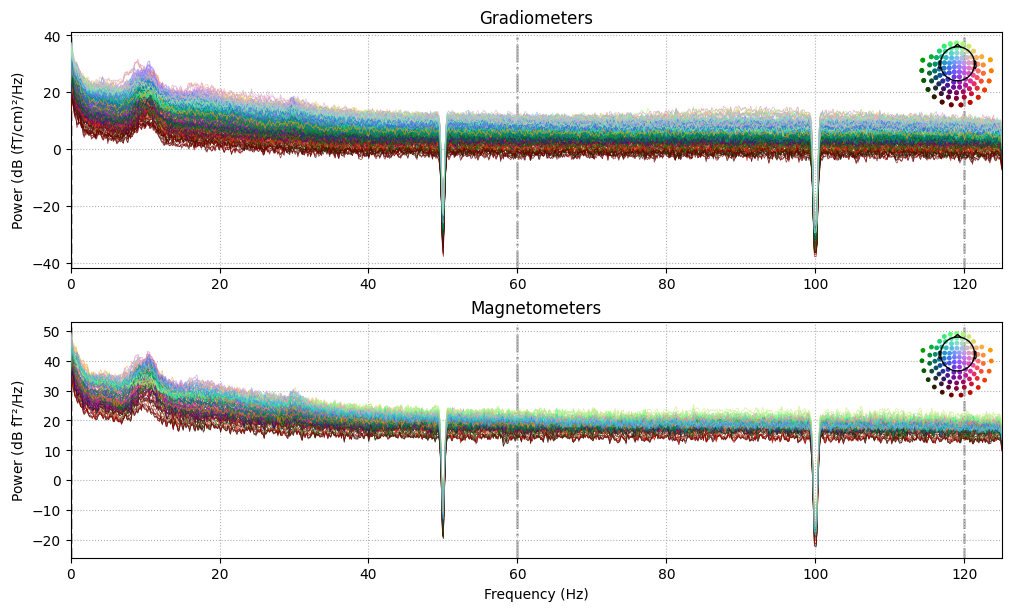

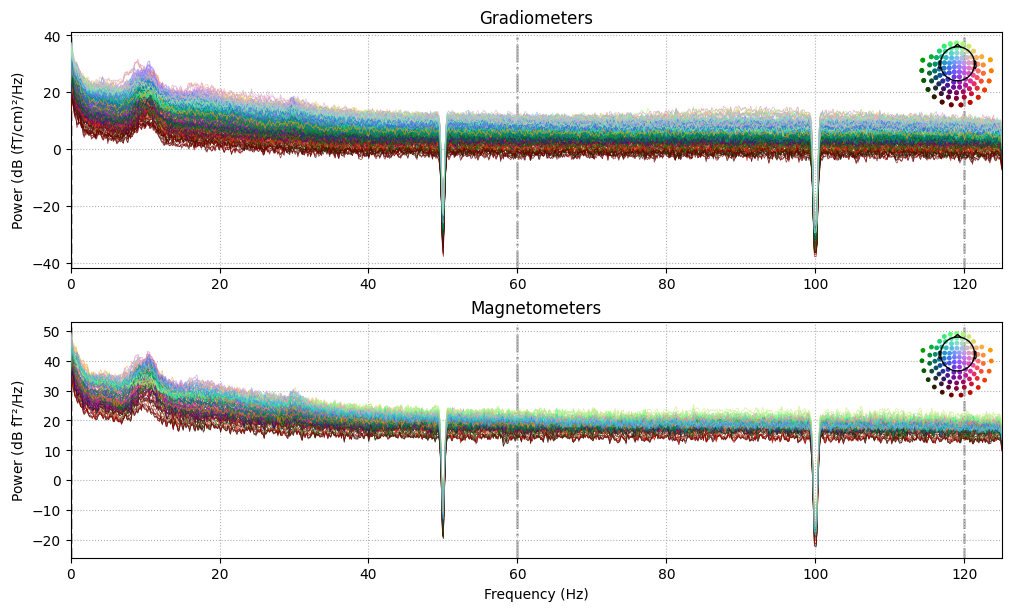

In [223]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


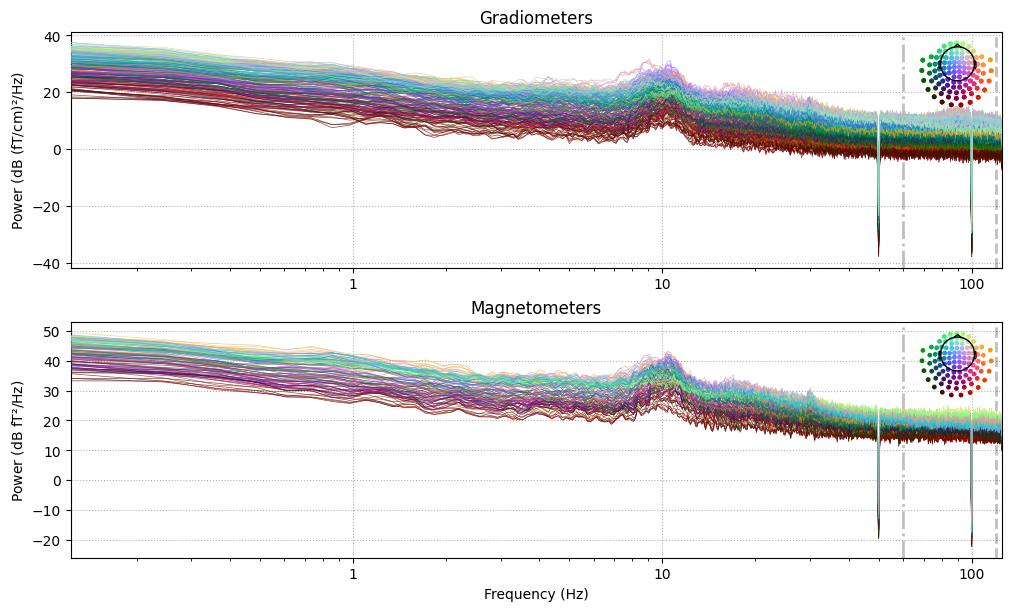

Error in callback <function _draw_all_if_interactive at 0x1382770a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

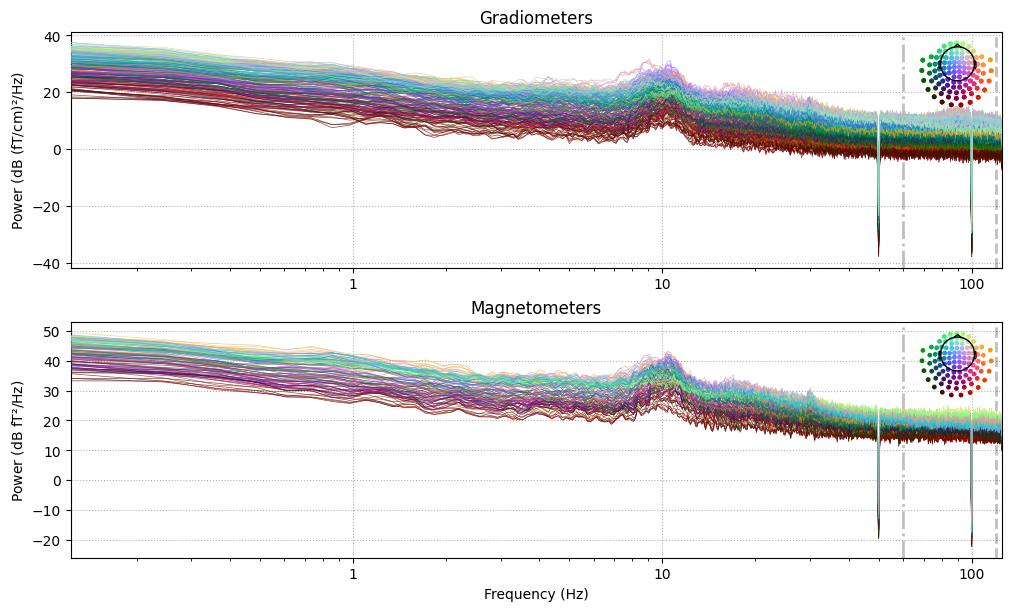

In [224]:
raw.plot_psd(xscale="log")

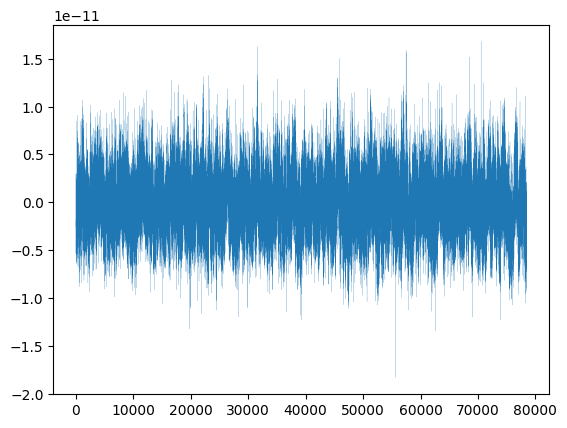

In [ ]:
X = data_matrix[2, 2000:-2000]
plt.plot(X, lw=.1)
plt.show()

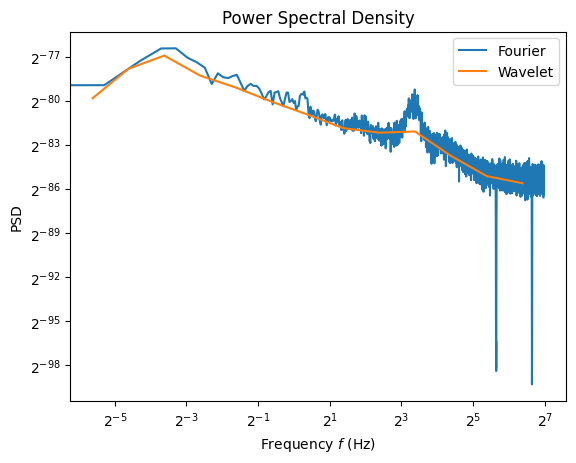

In [ ]:
from pymultifracs.viz import plot_psd
plot_psd(X, fs=sfreq)

In [ ]:
WT = wavelet_analysis(X, 'db6').integrate(1)

In [ ]:
WT.freq2scale(2.0, sfreq)
WT.scale2freq(9, sfreq)

np.float64(0.35511363636363635)

In [ ]:
dwt = mfa(WT, [(6, 11)])

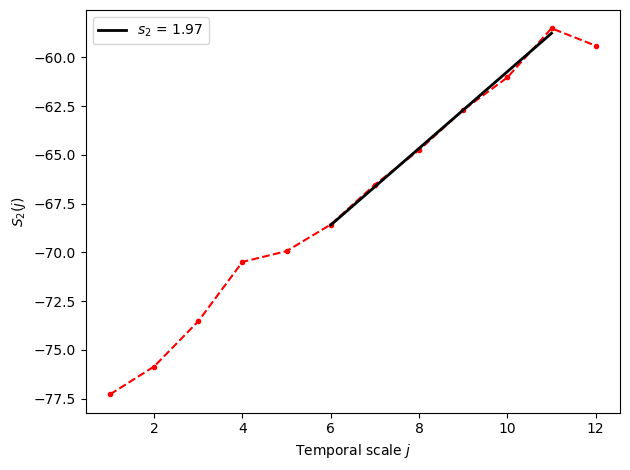

In [ ]:
dwt.structure.plot()

In [ ]:
H = float(dwt.structure.H.squeeze())

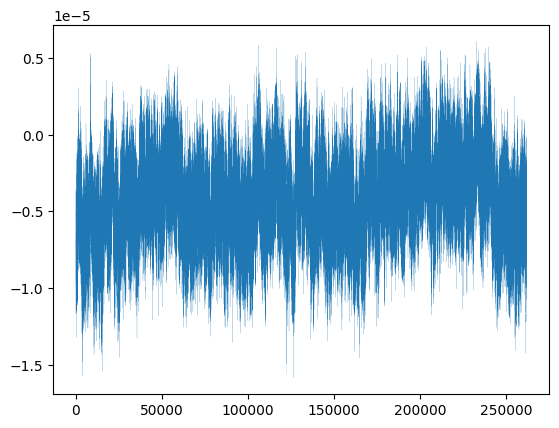

In [ ]:
from pymultifracs.simul import fbm
Y = fbm(shape=(2 ** 18), H=H)
plt.plot(np.diff(Y), lw=.1)

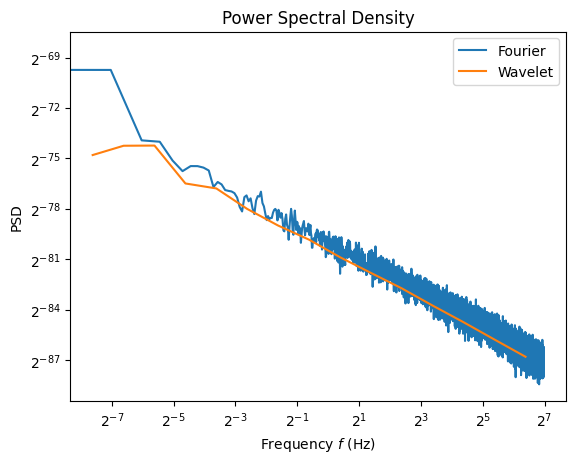

In [ ]:
from pymultifracs.viz import plot_psd
plot_psd(np.diff(Y) / np.diff(Y).std() * X.std(), sfreq)


(1.6155871338926322e-27, 1.0587911840678754e-22)

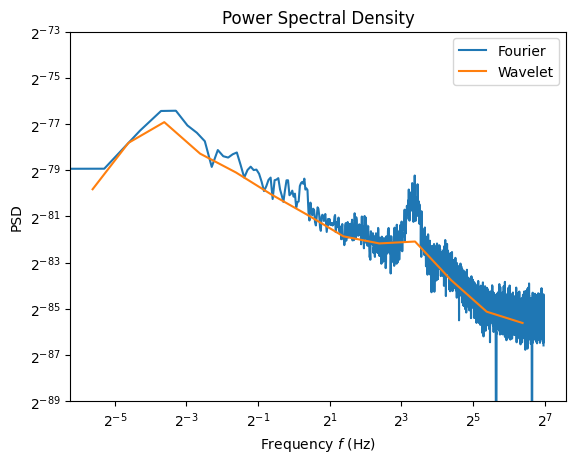

In [ ]:
plot_psd(X, sfreq)
plt.ylim(2**-89,2**-73)

## 2. Signal decomposition

### 2.1 Run Benchmark:

In [ ]:
def spectral_overlap_index(mode1, mode2, fs):
    """Compute spectral overlap index between two modes."""
    f1, Pxx1 = periodogram(mode1, fs=fs)
    f2, Pxx2 = periodogram(mode2, fs=fs)
    if not np.allclose(f1, f2):
        raise ValueError("Frequency bins do not match.")
    num = np.sum(np.minimum(Pxx1, Pxx2))
    den = min(np.sum(Pxx1), np.sum(Pxx2))
    return 0.0 if den == 0 else num / den

def compute_soi_matrix(modes, fs):
    """Compute full SOI matrix and return mean off-diagonal value."""
    K = len(modes)
    soi = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            soi[i, j] = spectral_overlap_index(modes[i], modes[j], fs)
    mean_soi = np.mean(soi[np.triu_indices(K, k=1)])
    return soi, mean_soi

def benchmark_vmd(signal, fs, param_grid):
    results = []
    spectra = {}
    for params in tqdm(param_grid, desc="Benchmarking VMD"):
        Nm = params['Nmodes']
        alpha = params['alpha']
        tau = params['tau']
        DC = params.get('DC', 0)
        init = params.get('init', 1)
        tol = params.get('tol', 1e-6)

        modes, _, _ = VMD(signal, alpha, tau, Nm, DC, init, tol)
        reconstructed = np.sum(modes, axis=0)
        mae = mean_absolute_error(signal, reconstructed)
        _, mean_soi = compute_soi_matrix(modes, fs)

        results.append({
            "alpha": alpha, "tau": tau, "K": Nm, "DC": DC, "init": init, "tol": tol,
            "MAE": mae, "mean_soi": mean_soi,
        })
        spectra[(alpha, tau, Nm)] = modes

    return pd.DataFrame(results), spectra

In [ ]:
# Build parameter grid
alphas = [0, 200, 500, 1000, 5000, 10000, 100000, 1000000]
taus = [0, 0.5, 1]
Nmodes_list = [4, 5, 6]
param_grid = [
    {'Nmodes': k, 'alpha': a, 'tau': t, 'DC': 1, 'init': 1, 'tol': 1e-6}
    for k, a, t in product(Nmodes_list, alphas, taus)
]

all_results = []

# Loop over MEG channels
for ch in range(n_channels_for_benchmark):
    sig = data_matrix[ch]
    sig = (sig - np.mean(sig)) / np.std(sig)  # Standardize

    print(f"\nBenchmarking channel {ch}")
    df_results, _ = benchmark_vmd(sig, fs, param_grid)
    df_results["channel"] = ch
    all_results.append(df_results)

# Save results
df_all = pd.concat(all_results, ignore_index=True)
df_all.to_csv("benchmark_vmd_first10_channels.csv", index=False)
print("✅ Results saved to benchmark_vmd_first10_channels.csv")


Results saved to benchmark_vmd_first10_channels.csv


In [ ]:
# Compute a global score as the sum of MAE and mean_soi
df_all["score"] = df_all["MAE"] + df_all["mean_soi"]

# Filter out alpha = 0 (non-valid configuration)
df_all = df_all[df_all["alpha"] != 0]

# Select best configuration (lowest score) for each channel
best_per_channel = (
    df_all.loc[df_all.groupby("channel")["score"].idxmin()]
    .sort_values("channel")
    .reset_index(drop=True)
)

display(best_per_channel)

# Select top 5 best global (alpha, tau) combinations
agg = (
    df_all.groupby(["alpha", "tau"])
    .agg(
        mean_MAE=("MAE", "mean"),
        mean_soi=("mean_soi", "mean"),
        score=("score", "mean"),
        n_channels=("channel", "nunique"),
    )
    .reset_index()
    .sort_values("score")
    .head(5)
)

display(agg)

In [ ]:
# display(best_per_channel)
# display(agg)

alpha  tau  K  DC  init       tol       MAE  mean_soi  channel     score
0    200  1.0  6   1     1  0.000001  0.000293  0.019646        0  0.019939
1    200  1.0  6   1     1  0.000001  0.001626  0.020041        1  0.021667
2    200  0.5  6   1     1  0.000001  0.000243  0.020650        2  0.020894

alpha  tau  mean_MAE  mean_soi     score  n_channels
2    200  1.0  0.000721  0.027596  0.028317           3
1    200  0.5  0.006384  0.028292  0.034676           3
5    500  1.0  0.050777  0.027259  0.078036           3
4    500  0.5  0.078541  0.024045  0.102587           3
0    200  0.0  0.088308  0.020869  0.109177           3

### 2.2 Run the Decompositions:

In [ ]:
# VMD configuration
max_modes = 5
method = "VMD"

best_vmd_params = {
    'meg': {
        'vmd_alpha': 200,
        'vmd_tau': 0.5,
        'vmd_DC': 1,
        'vmd_init': 0,
        'vmd_tol': 1e-7,
        'Nmodes': max_modes
    },
}

# Loop over MEG channels to decompose
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :]

    # Standardize the signal
    signal_scaled = (signal - np.mean(signal)) / np.std(signal)

    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    # Get decomposition parameters
    params = best_vmd_params['meg']

    # Run EMD/VMD decomposition
    modes_dict = run_all_decompositions(
        signal_in=signal_scaled,
        methods=methods,
        Fs=fs,
        Nmodes=params['Nmodes'],
        MaxEmdIMF=max_modes,
        MaxVmdModes=max_modes,
        vmd_alpha=params['vmd_alpha'],
        vmd_tau=params['vmd_tau'],
        vmd_DC=params['vmd_DC'],
        vmd_init=params['vmd_init'],
        vmd_tol=params['vmd_tol'],
        return_modes=True
    )
    # Rescale modes back to original signal scale
    for method in modes_dict:
        modes_dict[method] = modes_dict[method] * std + mean

    # Save decomposed modes
    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        out_path = os.path.join(method_dir, "modes", f"{name}_modes.npy")
        np.save(out_path, modes_dict[method])
        print(f"Saved modes for {method} - {name}")


In [ ]:
# Extract features from decomposed modes
for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)
    
    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")

        compute_features_from_modes_and_save(modes_path, features_path, fs)
        print(f"Features saved for {method} - {name}")


Features saved to ../results/real/meg_channel_0/VMD/features/meg_channel_0_std_features.csv
Features saved for VMD of meg_channel_0
Features saved to ../results/real/meg_channel_1/VMD/features/meg_channel_1_std_features.csv
Features saved for VMD of meg_channel_1
Features saved to ../results/real/meg_channel_2/VMD/features/meg_channel_2_std_features.csv
Features saved for VMD of meg_channel_2
Features saved to ../results/real/meg_channel_3/VMD/features/meg_channel_3_std_features.csv
Features saved for VMD of meg_channel_3
Features saved to ../results/real/meg_channel_4/VMD/features/meg_channel_4_std_features.csv
Features saved for VMD of meg_channel_4
Features saved to ../results/real/meg_channel_5/VMD/features/meg_channel_5_std_features.csv
Features saved for VMD of meg_channel_5
Features saved to ../results/real/meg_channel_6/VMD/features/meg_channel_6_std_features.csv
Features saved for VMD of meg_channel_6
Features saved to ../results/real/meg_channel_7/VMD/features/meg_channel_7_s

In [ ]:
# Plot original signal + decomposed modes
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :] 
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_std_modes.npy")
        
        if not os.path.exists(modes_path):
            print(f"Modes not found for {method} - {name}, skipping.")
            continue
        
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=ch_idx,
            output_dir=output_dir,
            duration=duration,             
            max_points=max_points,        
            spectrum_method='psd' 
        )
        print(f"Plots saved for {method} - {name}")


### 2.3 Analyze the Results:

##### Step 1: Compute Correlation Matrix Between Modes (Per Channel)

Computing inter-mode correlations: 100%|██████████| 306/306 [00:01<00:00, 153.64it/s]


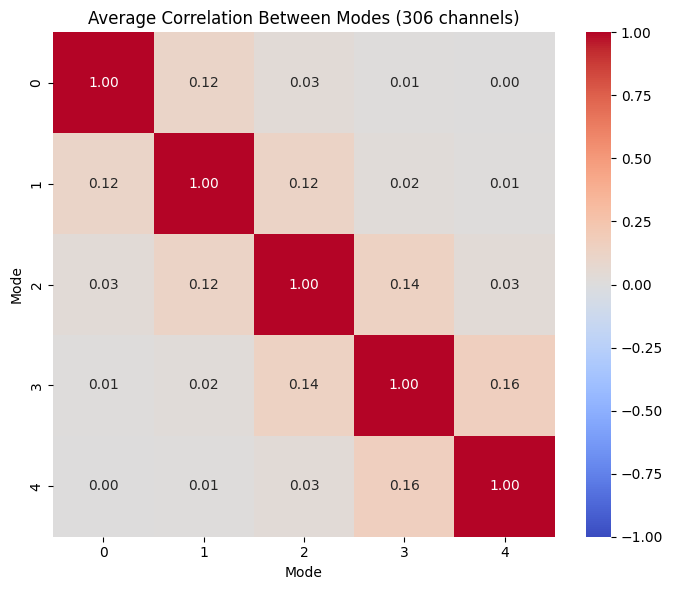

In [ ]:
all_corrs = []

for ch in tqdm(range(n_channels_to_process), desc="Computing inter-mode correlations"):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    modes = np.load(mode_path)

    if modes.shape[0] == Nmodes:
        modes = modes.T  # Ensure shape (n_timepoints, Nmodes)

    # Compute correlation matrix between modes for this channel
    corr = np.corrcoef(modes.T)
    all_corrs.append(corr)

# Average Correlation Matrix Across Channels
avg_corr = np.mean(all_corrs, axis=0)

# Plot the Average Correlation Matrix
plt.figure(figsize=(7, 6))
sns.heatmap(avg_corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Correlation Between Modes (Across All Channels)")
plt.xlabel("Mode")
plt.ylabel("Mode")
plt.tight_layout()
plt.show()


##### Step 2: Assign Modes to Physiological Frequency Bands

In [ ]:
# Frequency band classifier
def get_band(freq):
    if 1 <= freq < 4:
        return "Delta"
    elif 4 <= freq < 8:
        return "Theta"
    elif 8 <= freq < 13:
        return "Alpha"
    elif 13 <= freq < 30:
        return "Beta"
    elif 30 <= freq < 80:
        return "Low Gamma"
    elif freq >= 80:
        return "High Gamma"
    return "NotClassified"

In [ ]:
# Rebuild Full Feature DataFrame and Annotate Bands
all_rows = []

for ch in range(n_channels_to_process):
    name = f"meg_channel_{ch}"
    feat_path = os.path.join(output_base, name, method, "features", f"{name}_features.csv")
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    
    if not os.path.exists(feat_path) or not os.path.exists(mode_path):
        continue

    df = pd.read_csv(feat_path)
    modes = np.load(mode_path)

    for mode_idx in range(Nmodes):
        row = [ch, mode_idx]
        features = [
            df[f"{col}{mode_idx}"].iloc[0]
            for col in ["AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp"]
        ]
        band = get_band(features[6])  # Ppeak is at index 6
        all_rows.append(row + features + [band])

# Final feature DataFrame with bands
columns = ["channel", "mode", "AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", 
           "skew", "kurt", "Hmob", "Hcomp", "band"]

features_df_std = pd.DataFrame(all_rows, columns=columns)

In [ ]:
features_df["band"].value_counts()

band
Low Gamma        509
High Gamma       322
NotClassified    306
Alpha            305
Beta              88
Name: count, dtype: int64

##### STEP 3: K-means Clustering

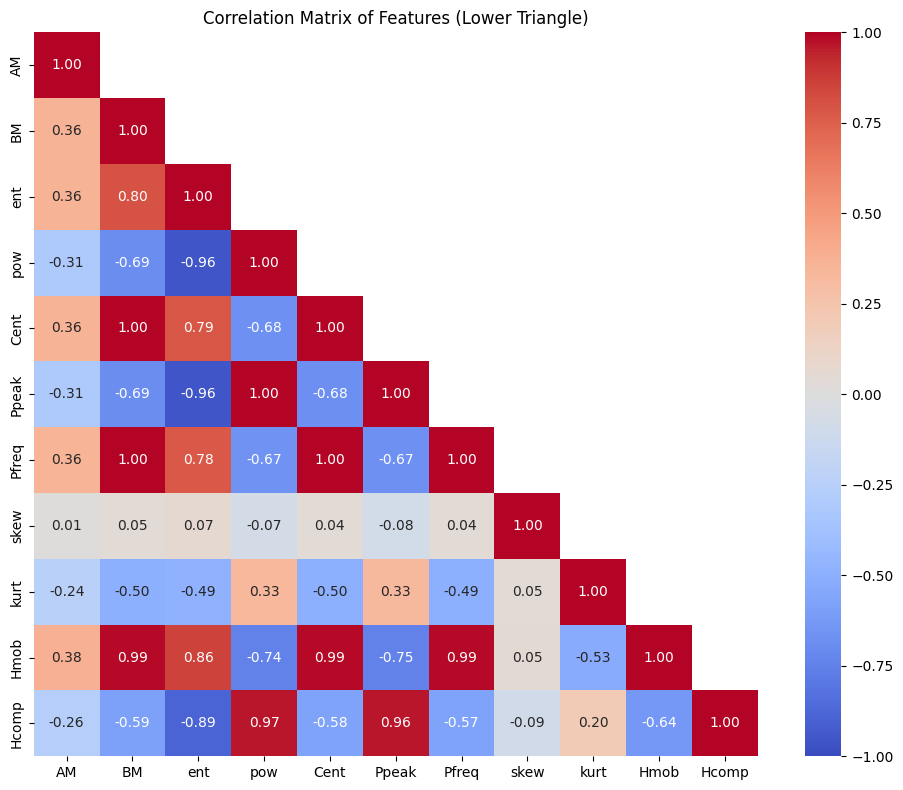

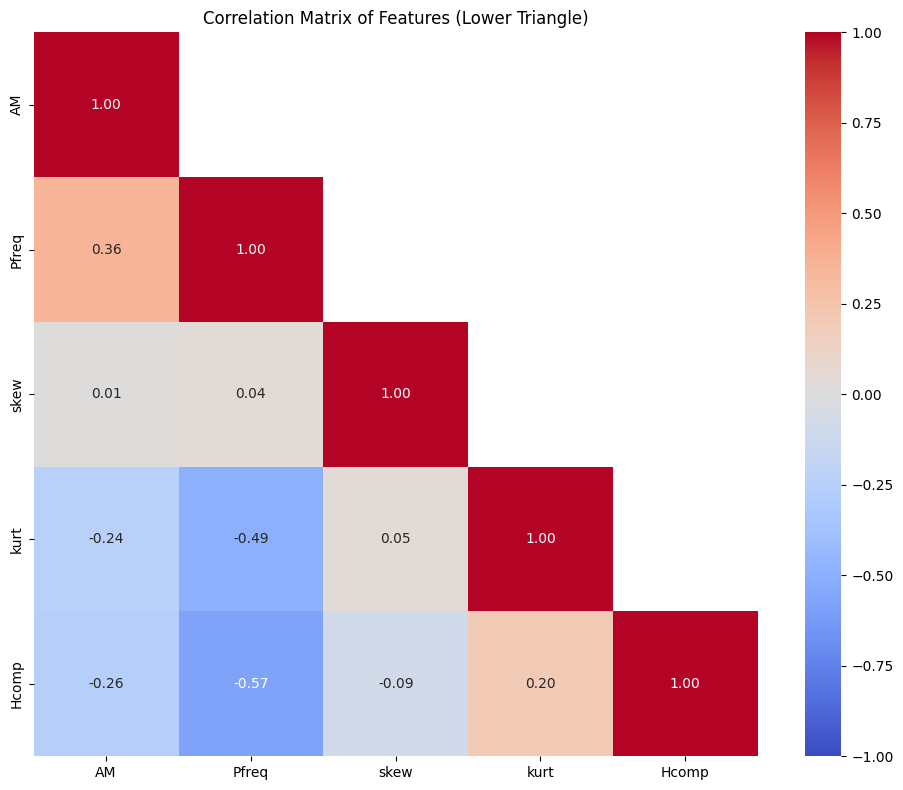

In [ ]:
# Visualize Feature Correlation Matrix between the features before clustering

features_to_drop = ["channel", "mode", "band"]
X = features_df.drop(columns=features_to_drop)

corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, square=True)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()


In [228]:
features_to_drop =['channel', 'mode', 'AM', 'BM', 'ent', 'pow', 'Cent', 'Ppeak',
       'skew', 'kurt', 'Hmob', 'Hcomp', 'band']

#features_to_drop =['channel', 'mode','band'] # Only if many features ares used for kmeans

X = features_df_std.drop(columns=features_to_drop)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

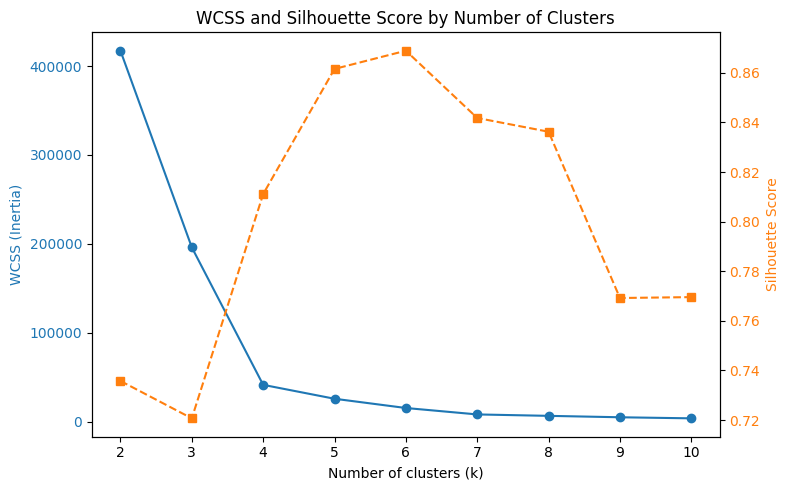

In [ ]:
# Clustering - Determine Optimal Number of Clusters


k_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in k_range:
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(X_scaled)
    wcss.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot WCSS and Silhouette Scores
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.plot(k_range, wcss, marker='o', color=color1)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title("KMeans Clustering Evaluation")

ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color=color2)
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.tight_layout()
plt.show()


In [ ]:
# PCA TO RUN ONLY IF MORE THAN ONE FEATURES IS USED FOR KMEANS
# pca = PCA(n_components=2)
# proj = pca.fit_transform(X_scaled)
# features_df["PC1"] = proj[:, 0]
# features_df["PC2"] = proj[:, 1]

In [229]:
# KMeans Clustering
kmeans = KMeans(n_clusters=6,init='k-means++',   random_state=42, n_init=100)
features_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# DBSCAN Clustering (Optional Tuning Needed)
dbscan = DBSCAN(eps=0.85, min_samples=50)
features_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

# MixtureGaussian Clustering
gaussianmixture = GaussianMixture(n_components=6 , init_params="k-means++")
features_df["gm_cluster"] = gaussianmixture.fit_predict(X_scaled)

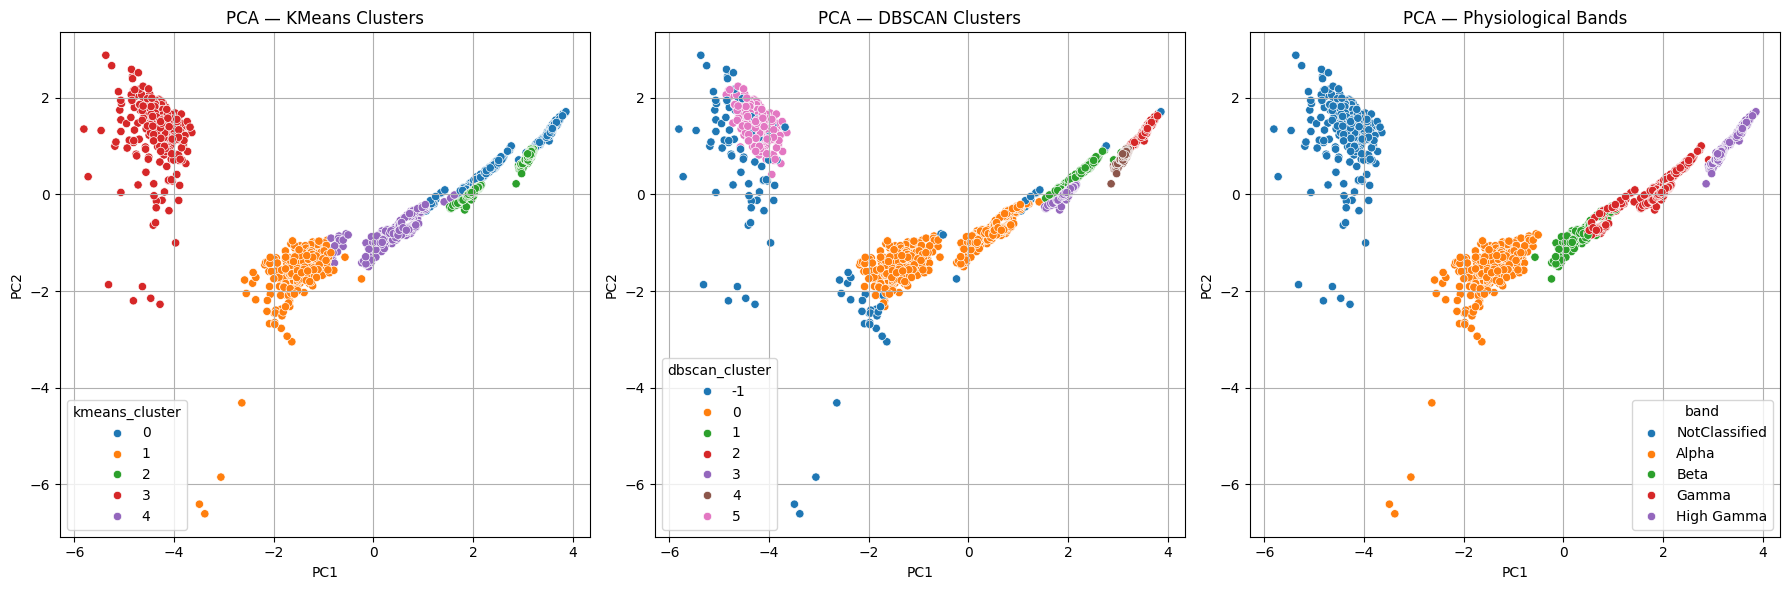

In [ ]:
#### TO RUN ONLY IF KMEANS ON MANY FEATURES + PCA

# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="kmeans_cluster", palette="tab10", ax=axs[0])
# axs[0].set_title("PCA — KMeans Clusters")

# sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="dbscan_cluster", palette="tab10", ax=axs[1])
# axs[1].set_title("PCA — DBSCAN Clusters")

# sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="band", palette="tab10", ax=axs[2])
# axs[2].set_title("PCA — Physiological Bands")

# for ax in axs:
#     ax.grid(True)
# plt.tight_layout()
# plt.show()

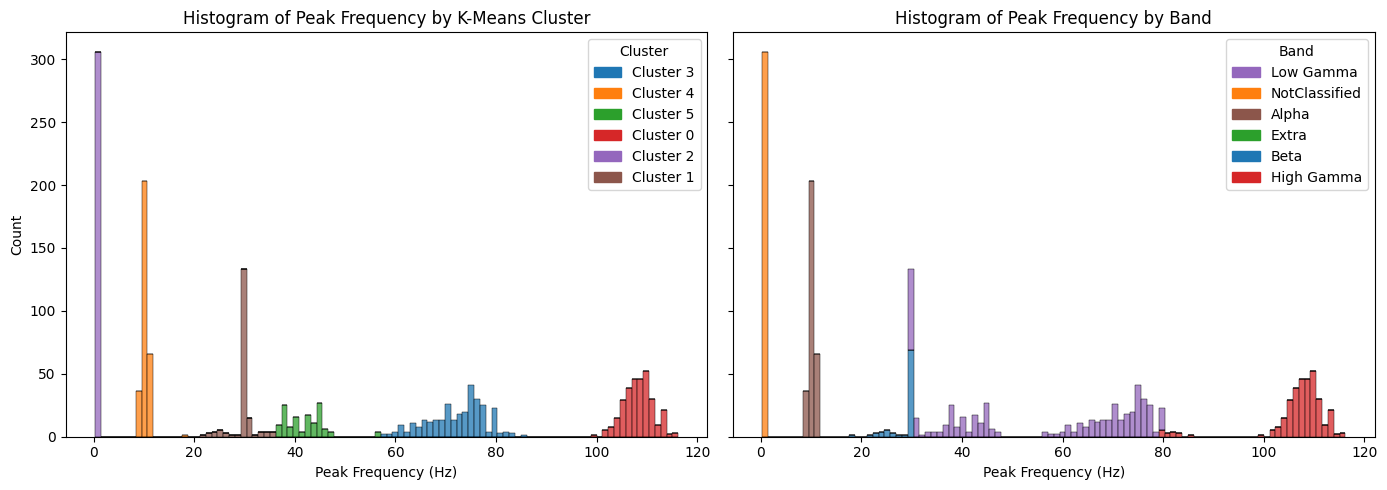

In [230]:
from matplotlib.patches import Patch

# Prepare color palette
colors = sns.color_palette("tab10", n_colors=6)

# Define custom cluster order (from lowest to highest peak frequency)
cluster_order = [3, 4, 5, 0, 2, 1]

# Map cluster ID to color in this order
cluster_palette = {cluster_id: colors[i] for i, cluster_id in enumerate(cluster_order)}

# Optional: Define band → cluster mapping if known
band_to_cluster = {
    'Low Gamma': 2,
    'NotClassified': 4,
    'Alpha': 1,
    'Extra': 5,  # Replace or rename if needed
    'Beta': 3,
    'High Gamma': 0,
}

# Map bands to same colors as their matching cluster
band_palette = {band: cluster_palette[cluster] for band, cluster in band_to_cluster.items()}

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# ==== (a) Histogram by K-Means Cluster ====
sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='kmeans_cluster',
    hue_order=cluster_order,
    bins=100,
    palette=cluster_palette,
    multiple='stack',
    ax=axes[0]
)
axes[0].set_title("Histogram of Peak Frequency by K-Means Cluster")
axes[0].set_xlabel("Peak Frequency (Hz)")
axes[0].set_ylabel("Count")

# Custom legend for clusters
cluster_legend = [
    Patch(color=cluster_palette[cl], label=f"Cluster {cl}")
    for cl in cluster_order
]
axes[0].legend(handles=cluster_legend, title="Cluster", loc='upper right')

# ==== (b) Histogram by Physiological Band ====
band_order = list(band_palette.keys())  # Preserve your band order

sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='band',
    hue_order=band_order,
    bins=100,
    palette=band_palette,
    multiple='stack',
    ax=axes[1]
)
axes[1].set_title("Histogram of Peak Frequency by Band")
axes[1].set_xlabel("Peak Frequency (Hz)")
axes[1].set_ylabel("Count")

# Custom legend for bands
band_legend = [
    Patch(color=band_palette[band], label=band)
    for band in band_order
]
axes[1].legend(handles=band_legend, title="Band", loc='upper right')

plt.tight_layout()
plt.show()


In [231]:
# KMeans vs. bands
cont_kmeans = pd.crosstab(features_df["kmeans_cluster"], features_df["band"])
display(cont_kmeans)

band            Alpha  Beta  High Gamma  Low Gamma  NotClassified
kmeans_cluster                                                   
0                   0     0         306          0              0
1                   0    87           0         92              0
2                   0     0           0          0            306
3                   0     0          16        286              0
4                 305     1           0          0              0
5                   0     0           0        131              0

In [240]:
# Save the full features DataFrame with clustering and band labels
output_path = os.path.join(output_base, "features_df_kmeans.csv")
features_df.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Saved full features DataFrame with cluster labels to:\n{output_path}")


✅ Saved full features DataFrame with cluster labels to:
../results/real/features_df_kmeans.csv


##### STEP 4: Analyze Clusters

In [233]:
required_cols = ["channel", "mode", "kmeans_cluster", "band", "signal"]

# Load mode signals from saved .npy files and merge with features_df metadata
modes_df = []
n_channels = features_df["channel"].nunique()

for ch in tqdm(range(n_channels), desc="Loading mode files"):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    if not os.path.exists(mode_path):
        print(f"⚠️ File missing: {mode_path}")
        continue

    modes = np.load(mode_path)
    for mode_idx in range(modes.shape[0]):
        match = features_df[(features_df["channel"] == ch) & (features_df["mode"] == mode_idx)]
        if match.empty:
            print(f"⚠️ No match for channel={ch}, mode={mode_idx}")
            continue
        row = match.iloc[0]
        modes_df.append({
            "channel": ch,
            "mode": mode_idx,
            "kmeans_cluster": row["kmeans_cluster"],
            "band": row["band"],
            "signal": modes[mode_idx]
        })

modes_df = pd.DataFrame(modes_df)

Loading mode files: 100%|██████████| 306/306 [00:02<00:00, 108.21it/s]


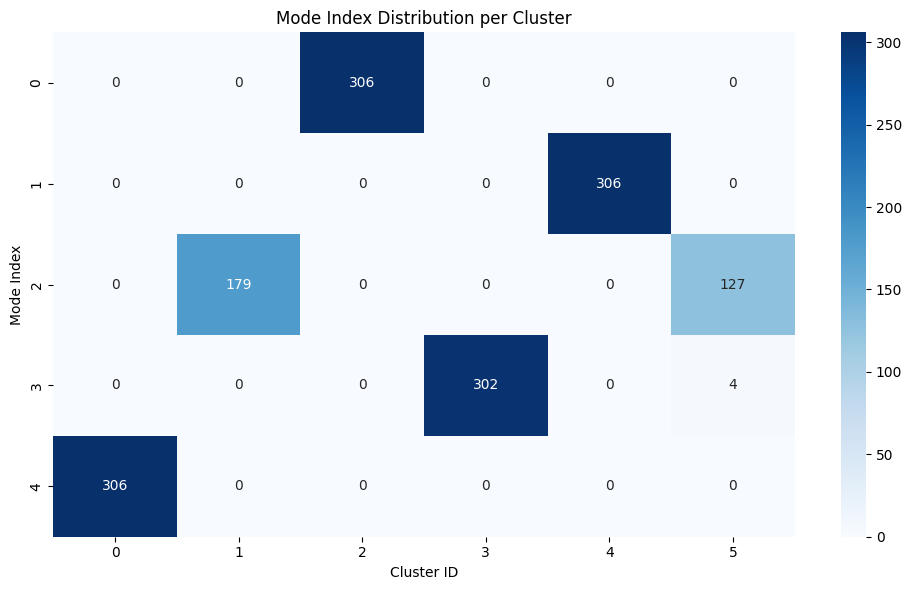

In [234]:
# Heatmap: Mode Index Distribution per Cluster

mode_distribution = modes_df.groupby(["mode", "kmeans_cluster"]).size().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(mode_distribution, annot=True, fmt="d", cmap="Blues")
plt.title("Mode Index Distribution per Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Mode Index")
plt.tight_layout()
plt.show()

* Mode 0 -> Cluster 2
* Mode 1 -> Cluster 4
* Mode 2 -> Clusters 1 and 5
* Mode 3 -> Cluster 3 
* Mode 4 -> Cluster 0 


In [235]:
# Group by cluster and compute average peak frequency
avg_pf_per_cluster = (
    features_df
    .groupby("kmeans_cluster")["Pfreq"]
    .mean()
    .sort_values()
)

print("Average Peak Frequency per Cluster (sorted):")
print(avg_pf_per_cluster)

Average Peak Frequency per Cluster (sorted):
kmeans_cluster
2      0.244141
4     10.348052
1     29.738783
5     41.941868
3     72.253499
0    108.251634
Name: Pfreq, dtype: float64


###### Compare Power Spectra of Modes Across Clusters

In [ ]:
# === Parameters ===
nperseg = 1024
eps = 1e-30  # Prevent log(0)
Q = 30       # Notch filter quality
notch_freqs = [50, 100]

# === Notch Filter Definition ===
def double_notch(signal, fs, freqs=notch_freqs, Q=30):
    """Apply notch filters at specified frequencies."""
    for f in freqs:
        b, a = iirnotch(f, Q, fs)
        signal = filtfilt(b, a, signal)
    return signal

# Format: (cluster_id, mode_id)
custom_order = [
    (2, 0),
    (4, 1),
    (1, 2),
    (5, 2),  # Intentional repetition
    (3, 3),
    (0, 4),
]

n_panels = len(custom_order)
fig, axes = plt.subplots(2, n_panels, figsize=(6 * n_panels, 10), sharex=True, sharey=True)
if n_panels == 1:
    axes = np.expand_dims(axes, axis=1)


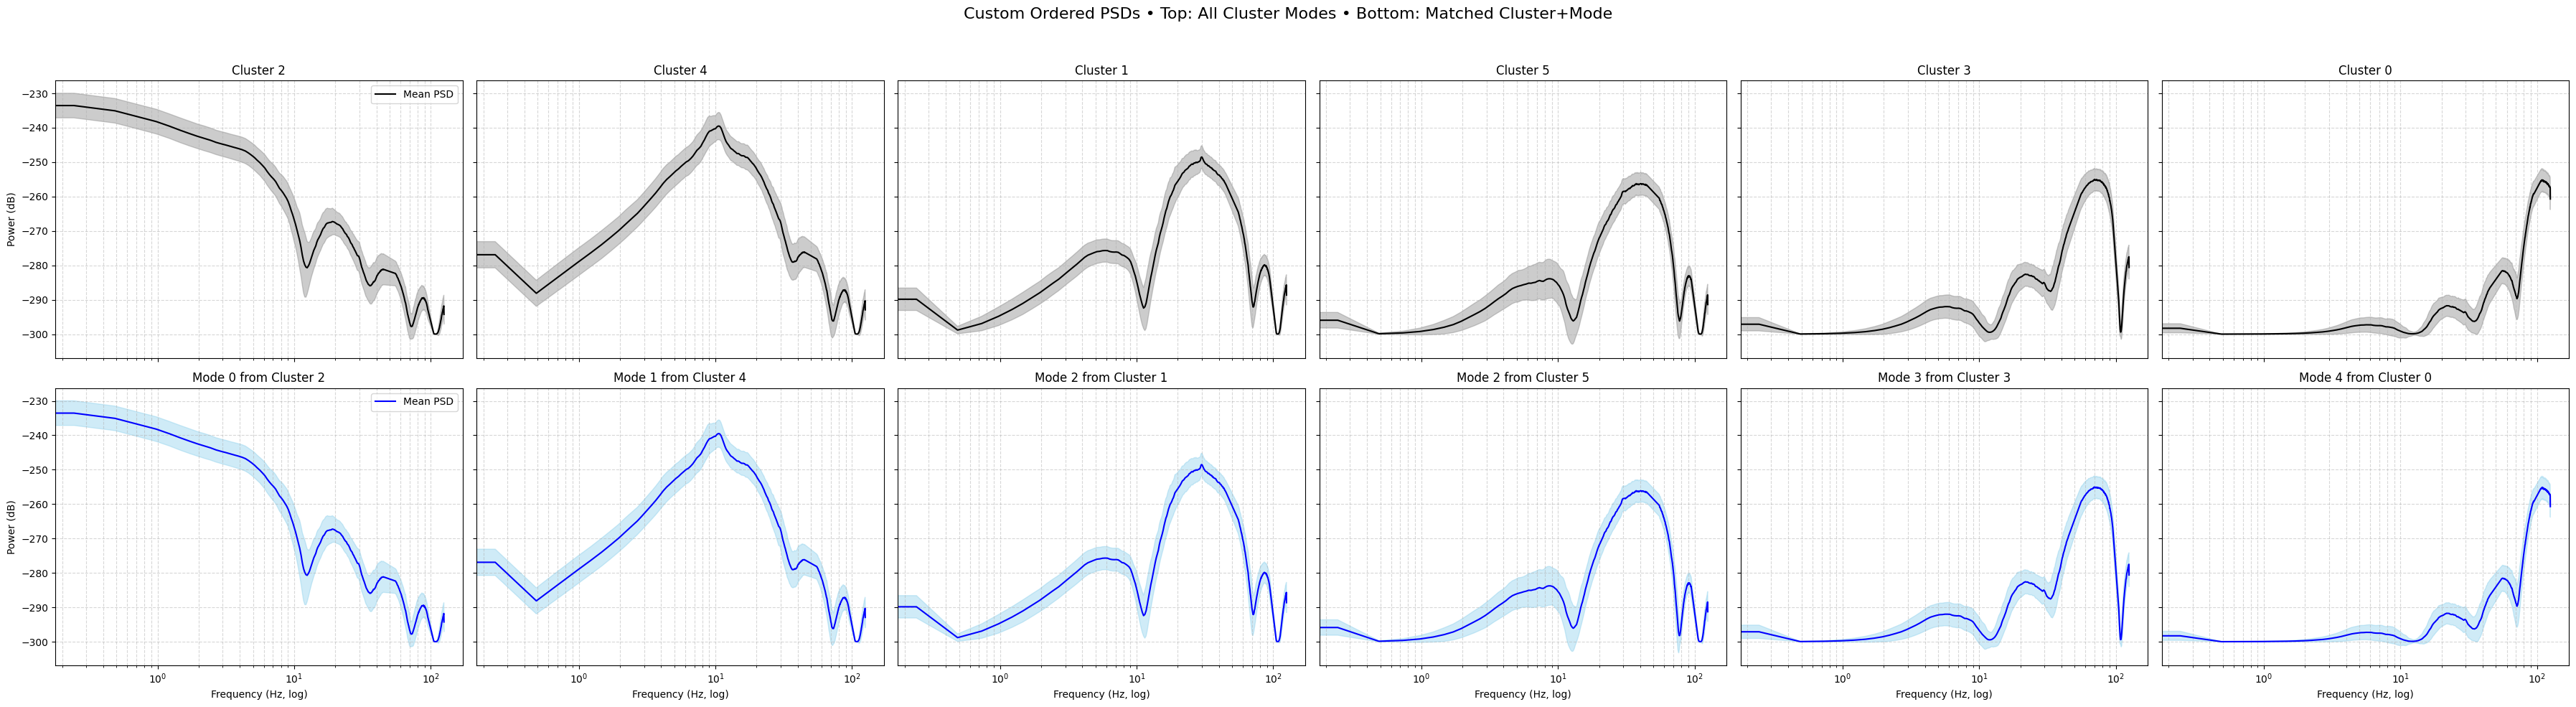

In [ ]:
# Top Row: Mean PSD of All Modes in a Cluster
for i, (cluster_id, mode_id) in enumerate(custom_order):
    ax = axes[0, i]
    cluster_df = features_df[features_df['kmeans_cluster'] == cluster_id]
    all_psd = []

    for _, row in cluster_df.iterrows():
        ch, m = row['channel'], row['mode']
        name = f"meg_channel_{ch}"
        mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(mode_path):
            continue
        modes = np.load(mode_path)
        if m >= modes.shape[0]:
            continue
        signal = double_notch(modes[m], fs)

        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
        mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
        all_psd.append(psd[mask])

    if not all_psd:
        ax.set_title(f"Cluster {cluster_id} (no data)")
        continue

    mean_psd = np.mean(all_psd, axis=0)
    std_psd = np.std(all_psd, axis=0)
    freqs_masked = freqs[mask]

    mean_db = 10 * np.log10(mean_psd + eps)
    std_db = 10 * np.log10(mean_psd + std_psd + eps) - mean_db

    ax.plot(freqs_masked, mean_db, color="black", label="Mean PSD")
    ax.fill_between(freqs_masked, mean_db - std_db, mean_db + std_db, color="gray", alpha=0.4)
    ax.set_xscale("log")
    ax.set_title(f"Cluster {cluster_id}")
    ax.grid(True, which='both', ls='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Power (dB)")
        ax.legend()

# Bottom Row: Matched Cluster & Mode PSD
for i, (cluster_id, mode_id) in enumerate(custom_order):
    ax = axes[1, i]
    match_df = features_df[
        (features_df['kmeans_cluster'] == cluster_id) &
        (features_df['mode'] == mode_id)
    ]
    all_psd = []

    for _, row in match_df.iterrows():
        ch = row['channel']
        name = f"meg_channel_{ch}"
        mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(mode_path):
            continue
        modes = np.load(mode_path)
        if mode_id >= modes.shape[0]:
            continue
        signal = double_notch(modes[mode_id], fs)

        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
        mask = ~((freqs > 45) & (freqs < 55)) & ~((freqs > 95) & (freqs < 105))
        all_psd.append(psd[mask])

    if not all_psd:
        ax.set_title(f"Mode {mode_id} (no data)")
        continue

    mean_psd = np.mean(all_psd, axis=0)
    std_psd = np.std(all_psd, axis=0)
    freqs_masked = freqs[mask]

    mean_db = 10 * np.log10(mean_psd + eps)
    std_db = 10 * np.log10(mean_psd + std_psd + eps) - mean_db

    ax.plot(freqs_masked, mean_db, color="blue", label="Mean PSD")
    ax.fill_between(freqs_masked, mean_db - std_db, mean_db + std_db, color="skyblue", alpha=0.4)
    ax.set_xscale("log")
    ax.set_title(f"Mode {mode_id} from Cluster {cluster_id}")
    ax.grid(True, which='both', ls='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Power (dB)")
        ax.legend()

# Final layout
for ax in axes[1, :]:
    ax.set_xlabel("Frequency (Hz, log)")

fig.suptitle("Custom Ordered PSDs • Top: All Cluster Modes • Bottom: Matched Cluster+Mode", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### STEP 5: Intra-Cluster Signal Correlation Using Hierarchical Clustering

In [ ]:
# Correlation Matrices within Each Cluster
cluster_corrs = {}
cluster_signals = {}

for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    signals = modes_df[modes_df["kmeans_cluster"] == clust_id]["signal"].tolist()
    n = len(signals)
    corr_mat = np.eye(n)  # Identity matrix (1 on diagonal)

    for i in range(n):
        for j in range(i+1, n):  # upper triangle only
            r, _ = pearsonr(signals[i], signals[j])
            corr_mat[i, j] = r
            corr_mat[j, i] = r

    cluster_corrs[clust_id] = corr_mat
    cluster_signals[clust_id] = signals

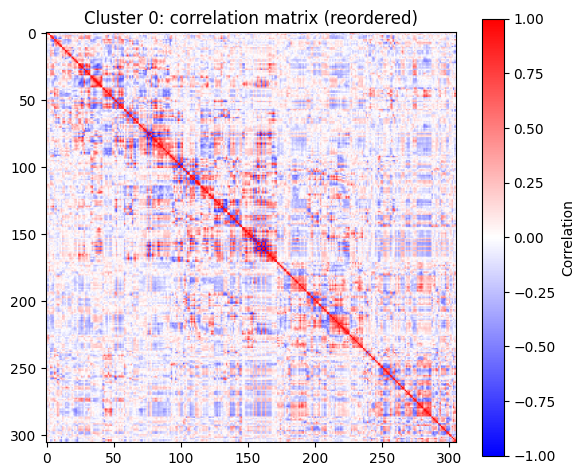

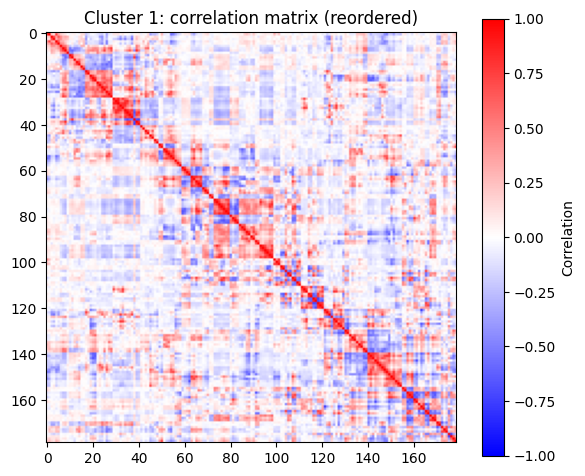

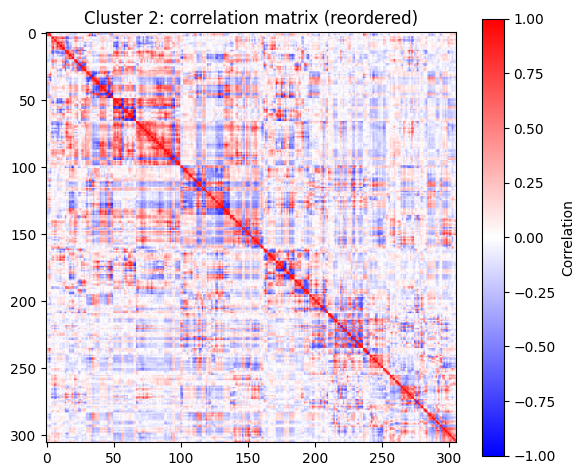

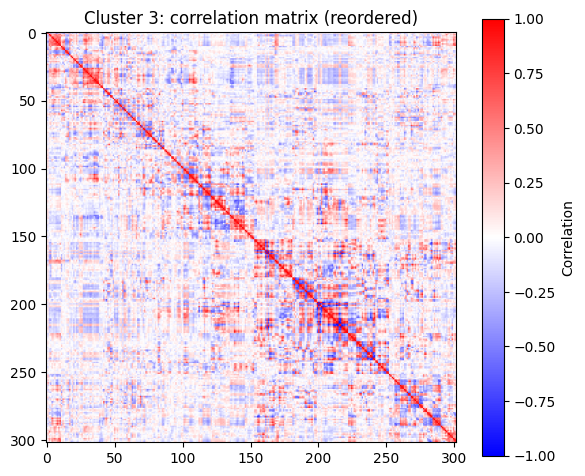

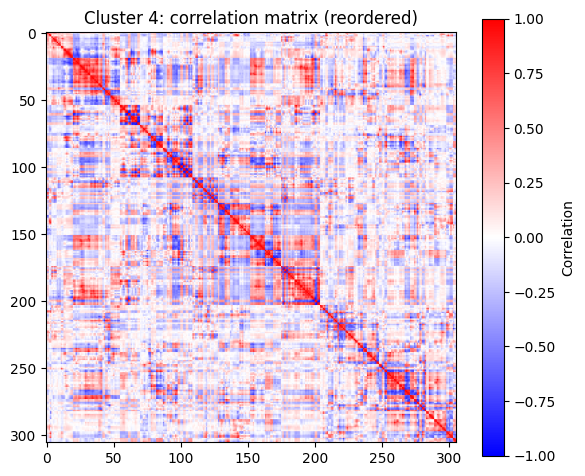

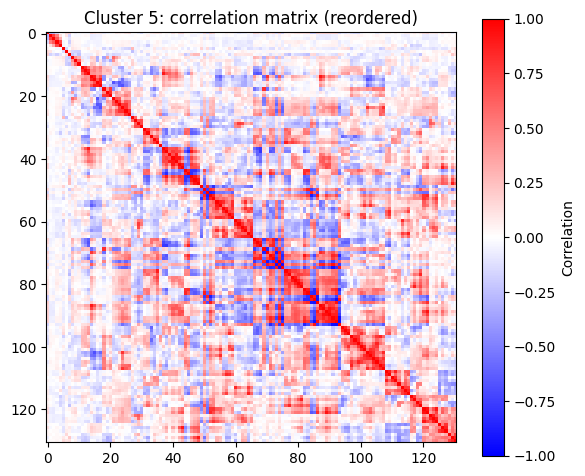

In [214]:
# Reorder Each Matrix Using Hierarchical Clustering
for clust_id, corr_mat in cluster_corrs.items():
    dist = 1 - np.abs(corr_mat)  # convert to distance matrix (range 0–1)
    condensed_dist = squareform(dist)  # convert to condensed format
    Z = linkage(condensed_dist, method='average')
    dendro = dendrogram(Z, no_plot=True)
    order = dendro['leaves']
    reordered_corr = corr_mat[np.ix_(order, order)]

    plt.figure(figsize=(6, 5))
    plt.imshow(reordered_corr, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation')
    plt.title(f"Cluster {clust_id}: Correlation Matrix (Reordered)")
    plt.tight_layout()
    plt.show()

## 3. Enveloppes extraction

In [174]:
extract_envelopes_modes(
    base_dir=output_base,
    method="VMD",
    sfreq=250,
    features_df_path="../results/real/benchmark/features_df.csv",
    overwrite=True  # Change to True to recompute envelopes even if they exist
)

🔍 Processing channel 0 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_0/VMD/envelopes/meg_channel_0_envelopes.npy
🔍 Processing channel 1 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_1/VMD/envelopes/meg_channel_1_envelopes.npy
🔍 Processing channel 2 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_2/VMD/envelopes/meg_channel_2_envelopes.npy
🔍 Processing channel 3 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_3/VMD/envelopes/meg_channel_3_envelopes.npy
🔍 Processing channel 4 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_4/VMD/envelopes/meg_channel_4_envelopes.npy
🔍 Processing channel 5 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_5/VMD/envelopes/meg_channel_5_envelopes.npy
🔍 Processing channel 6 with 5 modes...
✅ Saved envelopes to ../results/real/meg_channel_6/VMD/envelopes/meg_channel_6_envelopes.npy
🔍 Processing channel 7 with 5 modes...
✅ Saved envelopes to ../results/real/

In [ ]:
method = "VMD"
envelopes_list = [None] * len(modes_df)  # Pre-allocate list

# Group rows by channel to avoid reloading same file
for ch in tqdm(modes_df["channel"].unique(), desc="Assigning envelopes"):
    envelope_path = os.path.join(
        output_base,
        f"meg_channel_{ch}",
        method,
        "envelopes",
        f"meg_channel_{ch}_envelopes.npy"
    )

    if not os.path.exists(envelope_path):
        print(f"⚠️ Envelope file not found for channel {ch}")
        continue

    try:
        envelopes = np.load(envelope_path)
        # Filter rows for this channel
        rows = modes_df[modes_df["channel"] == ch]
        for idx, row in rows.iterrows():
            m = row["mode"]
            if m < envelopes.shape[0]:
                envelopes_list[idx] = envelopes[m]
            else:
                print(f"⚠️ Mode {m} out of range for channel {ch}")
    except Exception as e:
        print(f"❌ Error reading envelope for ch {ch}: {e}")

# Add the envelope column all at once
modes_df["envelope"] = envelopes_list

# Save the DataFrame
output_path = os.path.join(output_base, "modes_df_with_envelopes.csv")
modes_df.to_pickle("modes_df_with_enveloppes.pkl")
print("✅ Done. Saved 'modes_df_with_envelopesx")


Assigning envelopes: 100%|██████████| 306/306 [00:02<00:00, 118.21it/s]


✅ Done. Saved 'modes_df_with_envelopes.csv'


In [ ]:
cluster_corrs = {}
cluster_envelope = {}

for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    envelopes = modes_df[modes_df["kmeans_cluster"] == clust_id]["envelope"].tolist()
    n = len(envelopes)
    corr_mat = np.eye(n)  # initialize with 1s on diagonal

    for i in range(n):
        for j in range(i+1, n):  # only upper triangle
            r, _ = pearsonr(envelopes[i], envelopes[j])
            corr_mat[i, j] = r
            corr_mat[j, i] = r  # force symmetry

    cluster_corrs[clust_id] = corr_mat
    cluster_envelope[clust_id] = envelopes

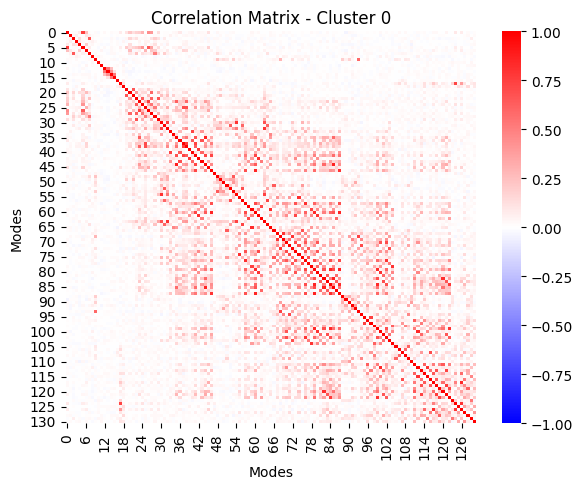

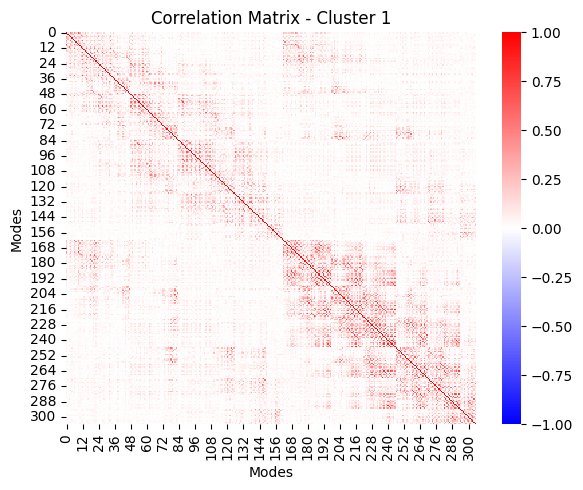

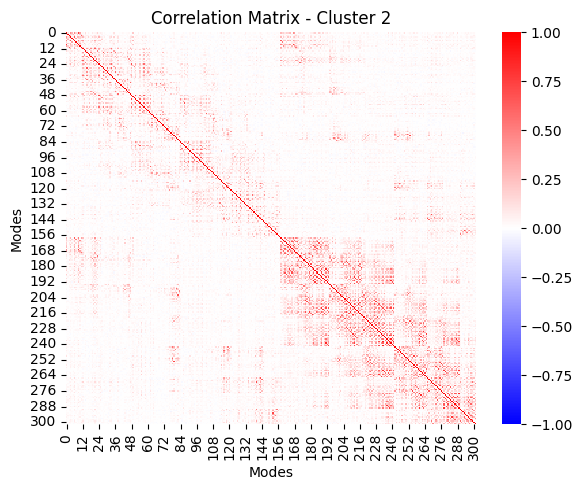

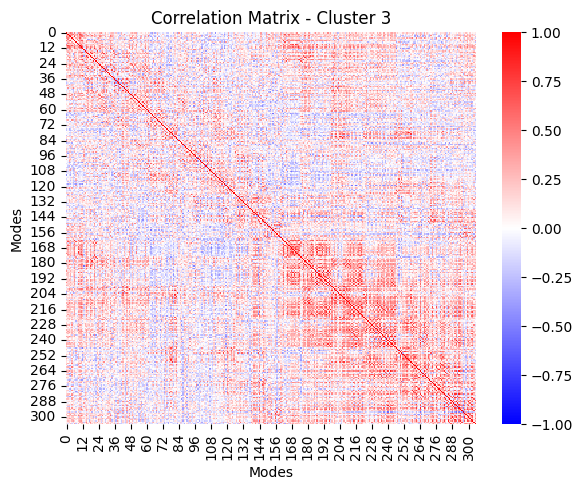

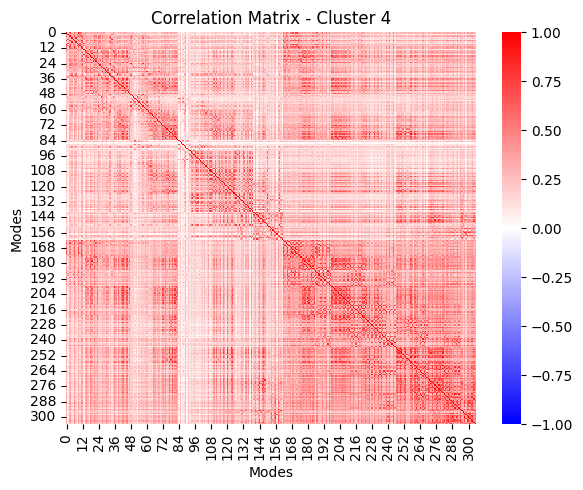

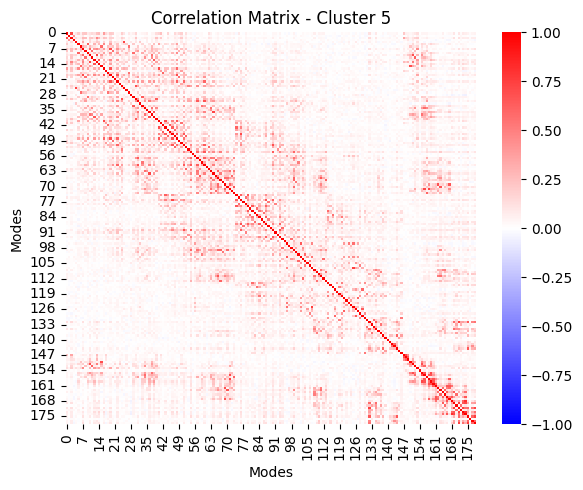

In [189]:
# Sort cluster IDs
cluster_ids = sorted(cluster_corrs.keys())

for clust_id in cluster_ids:
    corr_mat = cluster_corrs[clust_id]

    plt.figure(figsize=(6, 5))
    sns.heatmap(
    corr_mat,
    cmap='bwr',
    center=0,
    cbar=True,
    vmin=-1, 
    vmax=1 )
    plt.title(f"Correlation Matrix - Cluster {clust_id}")
    plt.xlabel("Modes")
    plt.ylabel("Modes")
    plt.tight_layout()
    plt.show()


In [289]:
# Inspect the first 10 rows of the 'envelope' column
for i in range(10):
    value = modes_df["envelope"].iloc[i]
    print(f"\n🔹 Row {i}:")
    print(f"  Type: {type(value)}")
    
    try:
        # Try to evaluate the string if needed
        if isinstance(value, str):
            import ast
            value = ast.literal_eval(value)
            print("  🛠️ Converted from string to list/array using ast.literal_eval")
        
        # Check length of the array or list
        length = len(value)
        print(f"  Length: {length} data points")
    except Exception as e:
        print(f"  ⚠️ Could not evaluate or measure length: {e}")



🔹 Row 0:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 1:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 2:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 3:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 4:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 5:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 6:
  Type: <class 'str'>
  ⚠️ Could not evaluate or measure length: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

🔹 Row 7:
  Type: <class 's

In [282]:
import ast



# STEP 2: Prepare to store results
cluster_pca_results = {}
pca_mfa_inputs = {}
summary_table = []

# STEP 3: Loop over clusters
for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    print(f"\n🔍 Processing cluster {clust_id}")
    
    cluster_envelopes = modes_df[modes_df["kmeans_cluster"] == clust_id]["envelope_a"].tolist()
    
    try:
        # ➤ 1. Stack as (n_timepoints × n_modes)
        X = np.column_stack(cluster_envelopes)
        print(f"  ➤ Matrix shape for PCA: {X.shape} (timepoints × modes)")
    except Exception as e:
        print(f"❌ Error stacking envelopes for cluster {clust_id}: {e}")
        continue
    
    # ➤ 2. PCA
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # ➤ 3. Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # ➤ 4. How many PCs explain ≥70% of the variance?
    n_components_70 = np.argmax(cumulative_variance >= 0.7) + 1
    print(f"  ➤ Components to explain ≥70% variance: {n_components_70}")

    # ➤ 5. Store results
    cluster_pca_results[clust_id] = {
        "pca": pca,
        "X_pca": X_pca,
        "explained_variance": explained_variance,
        "n_components_70": n_components_70
    }

    # ➤ 6. Save components for MFA
    pca_mfa_inputs[clust_id] = X_pca[:, :n_components_70].T  # shape: (n_components, time)

    # ➤ 7. Summary
    summary_table.append({
        "Cluster": clust_id,
        "Num Modes": len(cluster_envelopes),
        "PCs for ≥70% Var": n_components_70
    })

    # ➤ 8. Plot: variance + cumulative
    n_plot = min(20, len(explained_variance))
    fig, ax1 = plt.subplots(figsize=(7, 4))
    sns.barplot(x=np.arange(1, n_plot + 1), y=explained_variance[:n_plot], color="skyblue", ax=ax1)
    ax2 = ax1.twinx()
    ax2.plot(np.arange(1, n_plot + 1), cumulative_variance[:n_plot], color="red", marker="o", label="Cumulative Variance")
    ax2.axhline(0.7, color="darkred", linestyle="--", label="70% Threshold")
    ax2.set_ylim(0, 1.05)
    ax1.set_title(f"Explained Variance & Cumulative - Cluster {clust_id}")
    ax1.set_xlabel("Principal Component")
    ax1.set_ylabel("Explained Variance")
    ax2.set_ylabel("Cumulative Variance")
    fig.tight_layout()
    ax2.legend(loc="upper right")
    plt.show()

    # ➤ 9. Plot first PC
    plt.figure(figsize=(8, 3))
    plt.plot(X_pca[:, 0], label="1st Principal Component", color="purple")
    plt.title(f"First PCA Component - Cluster {clust_id}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()



🔍 Processing cluster 0


KeyError: 'envelope_a'

| Cluster | Peak?               | Envelope Correlation    | Physiological Confidence | Comment                             |
|---------|---------------------|--------------------------|---------------------------|--------------------------------------|
| **4**   | ✅ Very clear alpha  | ✅ Strong and structured | ✅✅✅ ✅ High              | This is a validated alpha rhythm     |
| **2**   | ❓ Broad bump        | ❓ Medium                | ❓ Possible low-freq rhythm | Needs more validation               |
| **1**   | ❓ Broad beta        | ❓ Weak                  | ❓ May be motor-related    | Possibly task-related                |
| **5**   | ❓ Flat/high beta    | ❌ Weak                  | ❌ Low                    | Not clearly physiological            |
| **3**   | ❓ Gamma-ish         | ❌ Sparse                | ❌ Low                    | Possibly artifact                    |
| **0**   | ❌ None              | ❌ None                  | ❌ Very low               | Likely noise or unstructured         |


## 5. MFA

Processing signal: meg_channel_0


<Figure size 800x400 with 0 Axes>

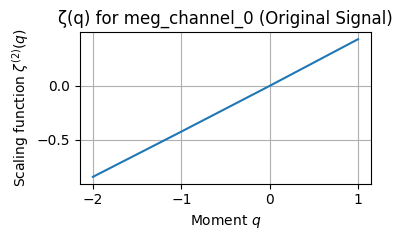

<Figure size 800x400 with 0 Axes>

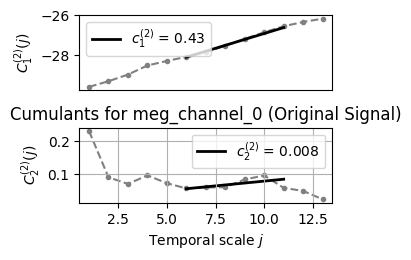

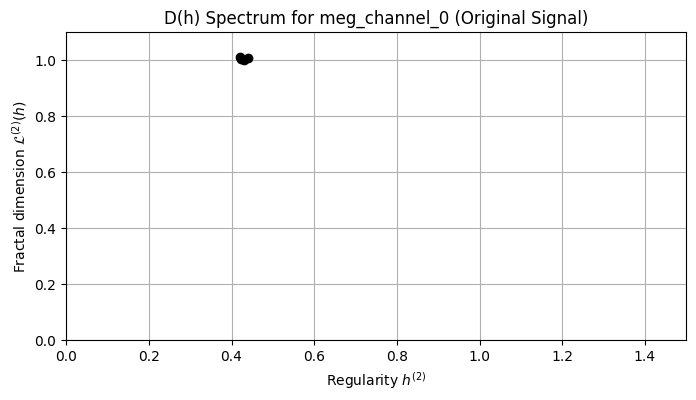

Processing signal: meg_channel_1


<Figure size 800x400 with 0 Axes>

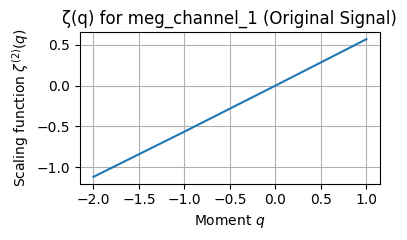

<Figure size 800x400 with 0 Axes>

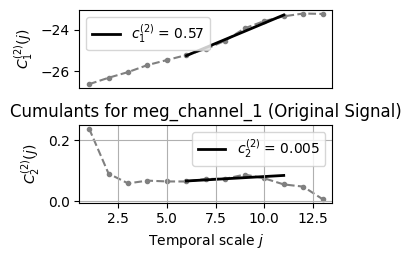

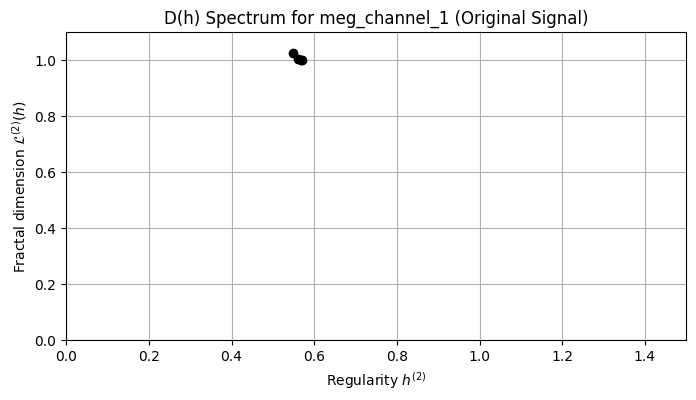

Processing signal: meg_channel_2


<Figure size 800x400 with 0 Axes>

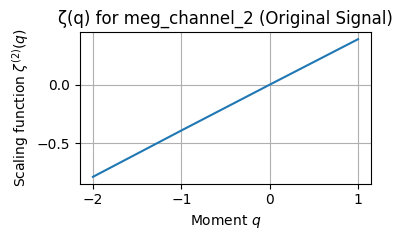

<Figure size 800x400 with 0 Axes>

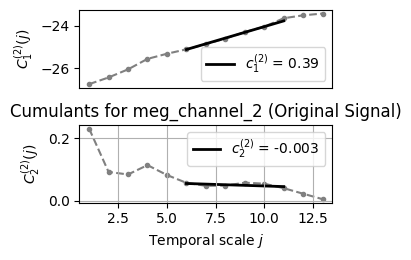

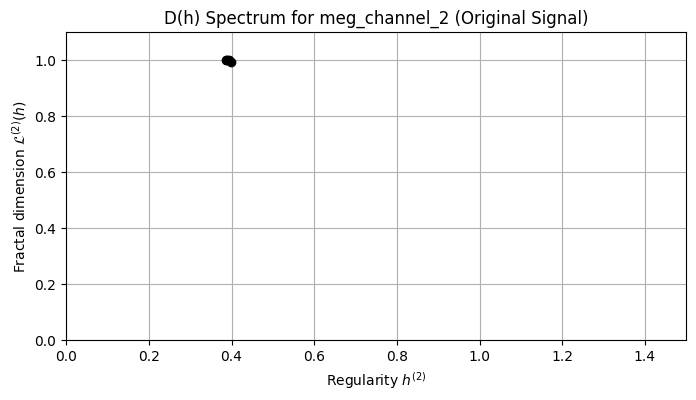

Processing signal: meg_channel_3


<Figure size 800x400 with 0 Axes>

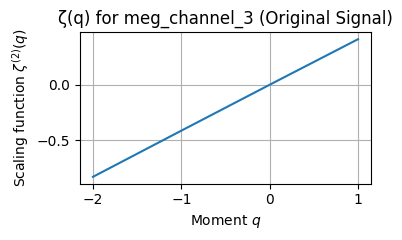

<Figure size 800x400 with 0 Axes>

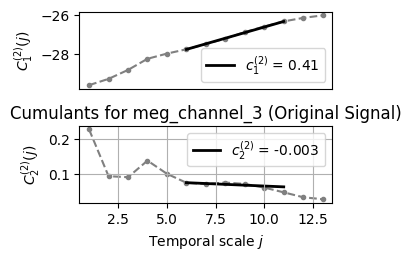

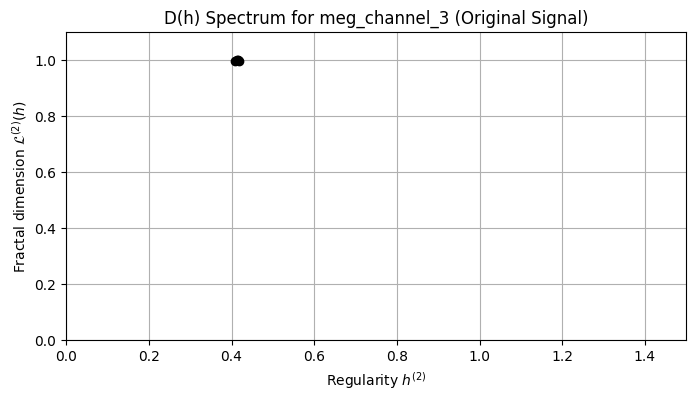

Processing signal: meg_channel_4


<Figure size 800x400 with 0 Axes>

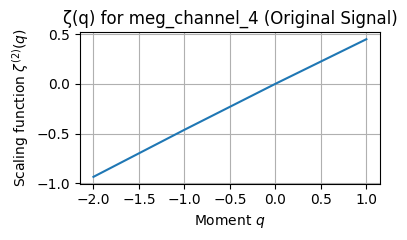

<Figure size 800x400 with 0 Axes>

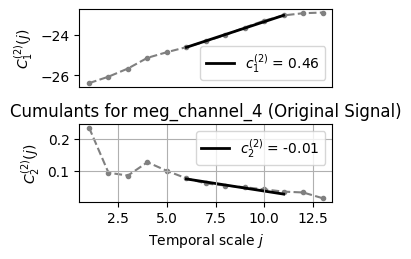

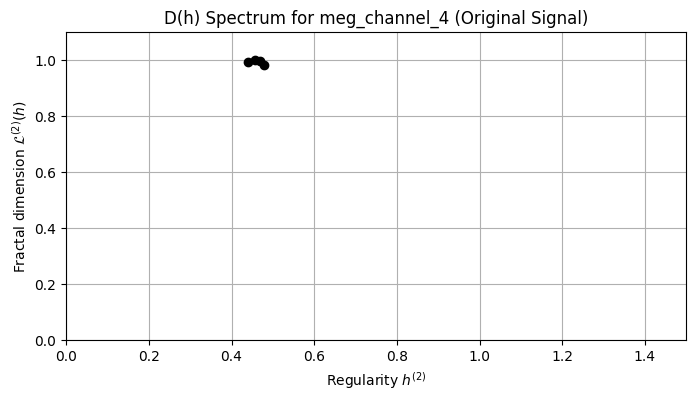

Processing signal: meg_channel_5


<Figure size 800x400 with 0 Axes>

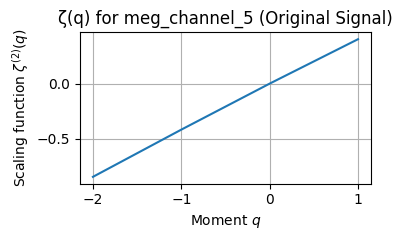

<Figure size 800x400 with 0 Axes>

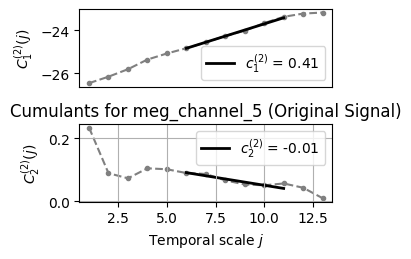

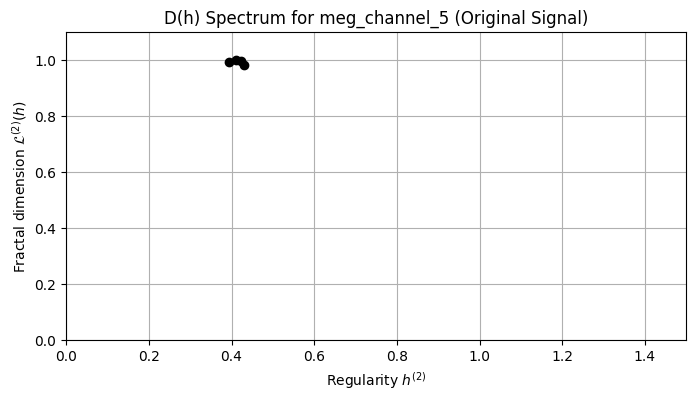

Processing signal: meg_channel_6


<Figure size 800x400 with 0 Axes>

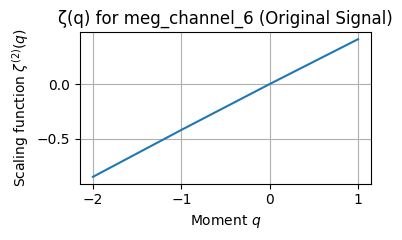

<Figure size 800x400 with 0 Axes>

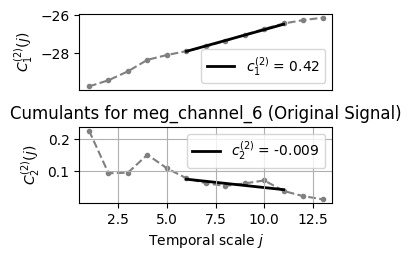

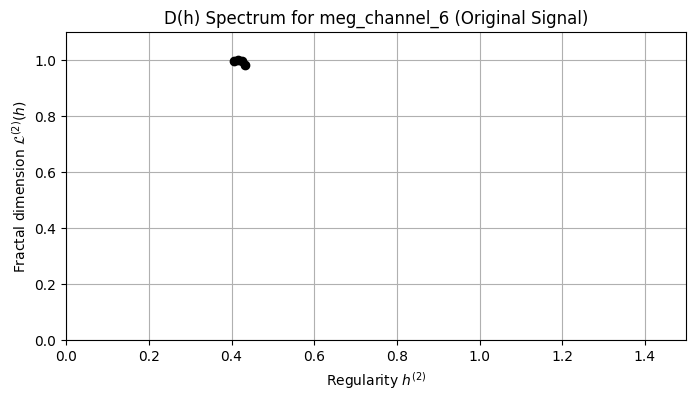

Processing signal: meg_channel_7


<Figure size 800x400 with 0 Axes>

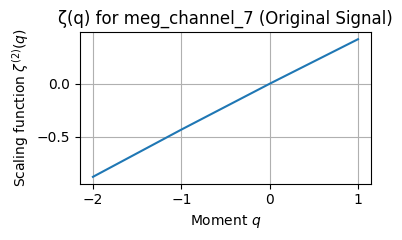

<Figure size 800x400 with 0 Axes>

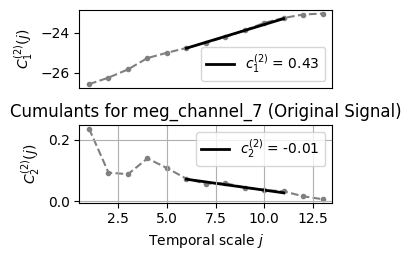

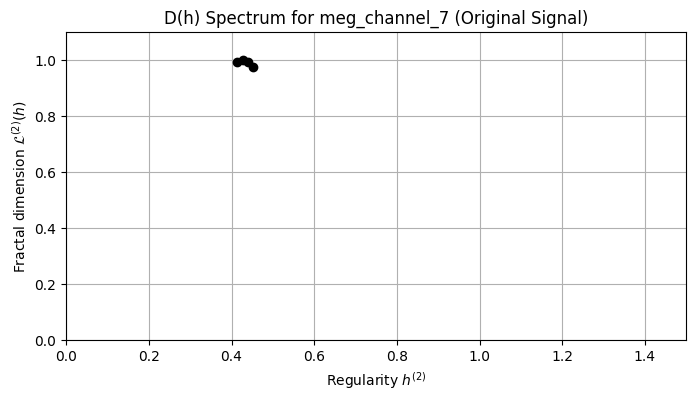

Processing signal: meg_channel_8


<Figure size 800x400 with 0 Axes>

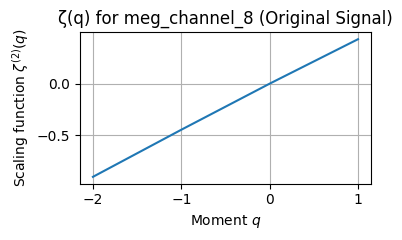

<Figure size 800x400 with 0 Axes>

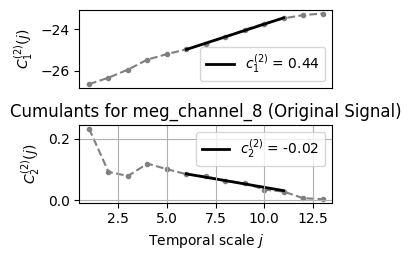

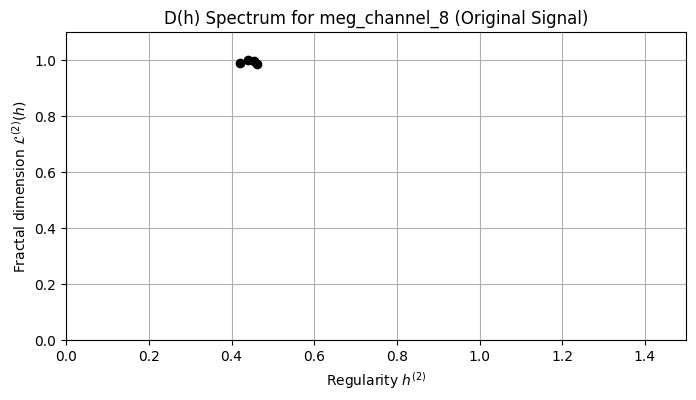

Processing signal: meg_channel_9


<Figure size 800x400 with 0 Axes>

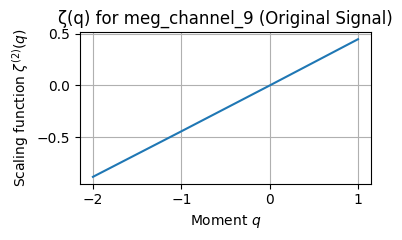

<Figure size 800x400 with 0 Axes>

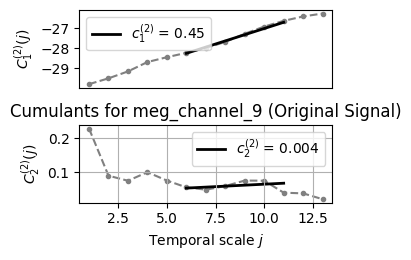

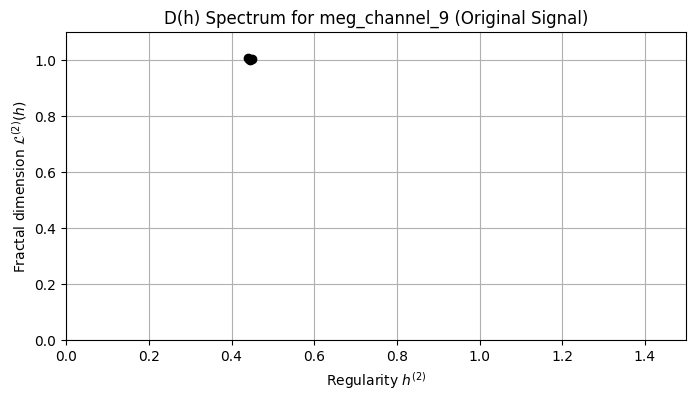

In [ ]:
scaling_ranges = [(6, 11)]
q_vals = np.arange(-2, 2)
summary_records = []
methods = ["VMD"]


signal_list = [data_matrix[ch_idx, :] for ch_idx in range(n_channels_to_process)]
signal_names = [f"meg_channel_{ch_idx}" for ch_idx in range(n_channels_to_process)]


for signal, name in zip(signal_list, signal_names):
    print(f"Processing signal: {name}")

    # MFA on original signal
    pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
    plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")
    summary_records.append({
        "Signal": name,
        "Mode": "Original",
        "Log-cumulant 1": pwt_signal.cumulants.values[0],
        "Log-cumulant 2": pwt_signal.cumulants.values[1]

    })

    for method in methods:
        modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(modes_path):
            print(f"Modes not found for {name} / {method} at {modes_path}")
            continue

        modes = np.load(modes_path)
        print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

        for idx, mode in enumerate(modes):
            pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
            #plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
            summary_records.append({
                "Signal": name,
                "Mode": f"{method} Mode {idx}",
                "Log-cumulant 1": pwt_mode.cumulants.values[0],
                "Log-cumulant 2": pwt_mode.cumulants.values[1]
            })

summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [103]:
summary_df['C1_flat'] = summary_df['Log-cumulant 1'].apply(lambda arr: arr.flatten())
summary_df['C2_flat'] = summary_df['Log-cumulant 2'].apply(lambda arr: arr.flatten())

# Check the new columns
summary_df

Signal      Mode                                     Log-cumulant 1  \
0  meg_channel_0  Original  [[[-29.602716263113127]], [[-29.31714420502243...   
1  meg_channel_1  Original  [[[-26.632769042210377]], [[-26.32331016613688...   
2  meg_channel_2  Original  [[[-26.754338789383926]], [[-26.43815269437106...   
3  meg_channel_3  Original  [[[-29.600312825628283]], [[-29.27875497000801...   
4  meg_channel_4  Original  [[[-26.391888594459683]], [[-26.07152800240672...   
5  meg_channel_5  Original  [[[-26.456191512475694]], [[-26.15505306581282...   
6  meg_channel_6  Original  [[[-29.778825093468583]], [[-29.45228477191572...   
7  meg_channel_7  Original  [[[-26.57710102709813]], [[-26.25151113276623]...   
8  meg_channel_8  Original  [[[-26.64754944140002]], [[-26.334243647534766...   
9  meg_channel_9  Original  [[[-29.787243608197624]], [[-29.49705786568036...   

                                      Log-cumulant 2  \
0  [[[0.23107844912306064]], [[0.0905390461256274...   
1  [[[0.2380243922268619]], [[0.09043441583366985...   
2  [[[0.23160975464213607]], [[0.0923626449457515...   
3  [[[0.22677845672797048]], [[0.0932712993721907...   
4  [[[0.2359528943073883]], [[0.09367060402428251...   
5  [[[0.234499896149714]], [[0.08924672360114982]...   
6  [[[0.2273296678171164]], [[0.09327419226201528...   
7  [[[0.2359377924033197]], [[0.09337817495134004...   
8  [[[0.23286342051142128]], [[0.0918628190031540...   
9  [[[0.2285977707517759]], [[0.08930925421066149...   

                                             C1_flat  \
0  [-29.602716263113127, -29.317144205022434, -28...   
1  [-26.632769042210377, -26.32331016613688, -26....   
2  [-26.754338789383926, -26.43815269437106, -26....   
3  [-29.600312825628283, -29.27875497000801, -28....   
4  [-26.391888594459683, -26.07152800240672, -25....   
5  [-26.456191512475694, -26.155053065812826, -25...   
6  [-29.778825093468583, -29.45228477191572, -28....   
7  [-26.57710102709813, -26.25151113276623, -25.8...   
8  [-26.64754944140002, -26.334243647534766, -25....   
9  [-29.787243608197624, -29.497057865680365, -29...   

                                             C2_flat  
0  [0.23107844912306064, 0.09053904612562746, 0.0...  
1  [0.2380243922268619, 0.09043441583366985, 0.05...  
2  [0.23160975464213607, 0.09236264494575153, 0.0...  
3  [0.22677845672797048, 0.0932712993721907, 0.09...  
4  [0.2359528943073883, 0.09367060402428251, 0.08...  
5  [0.234499896149714, 0.08924672360114982, 0.072...  
6  [0.2273296678171164, 0.09327419226201528, 0.09...  
7  [0.2359377924033197, 0.09337817495134004, 0.08...  
8  [0.23286342051142128, 0.09186281900315407, 0.0...  
9  [0.2285977707517759, 0.08930925421066149, 0.07...